In [1]:
import os
import io
import trimesh
import b3d
import genjax
import jax
import b3d.bayes3d as bayes3d
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
from genjax import Pytree
# from genjax._src.core.serialization.msgpack import msgpack_serialize

In [2]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/lf_0/",)

mesh_file_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/all_flex_meshes/",)

In [3]:
def extract_mesh(hdf5_file_path):
    with h5py.File(hdf5_file_path, "r") as f:
        # extract object info
        object_ids = np.array(f['static']['object_ids'])
        model_names = np.array(f['static']['model_names'])
        # print(model_names)
        assert len(object_ids) == len(model_names)
        distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else None
        occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else None
        meshes_faces = [np.array(f['static']['mesh'][f'faces_{idx}']) for idx in range(len(object_ids))]
        meshes_vertices = [np.array(f['static']['mesh'][f'vertices_{idx}']) for idx in range(len(object_ids))]
        distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
        occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
        excluded_model_ids = distractor_ids+occluder_ids
        excluded_model_names = [model_names[idx].decode('UTF-8') for idx in excluded_model_ids]
        object_meshes = [(vertex, face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in excluded_model_ids]
    return excluded_model_names, object_meshes


In [6]:
distractor_occluder = {}

for path, dirs, files in os.walk(physion_assets_path):
    for name in (files + dirs):
        if name.endswith('.hdf5'):
            print(name)
            model_names, meshes = extract_mesh(os.path.join(path, name))
            # print(model_names)
            for model_name, mesh in zip(model_names, meshes):
                # print(model_name)
                if name not in distractor_occluder.keys():
                    distractor_occluder[model_name] = mesh

{'b03_basset_hound': (array([[ 4.9540866e-02,  2.6822695e-01, -7.0214503e-02],
         [ 2.7037974e-02,  2.7848196e-01, -6.9815196e-02],
         [ 2.7027201e-02,  2.7215543e-01, -4.3932665e-02],
         ...,
         [ 2.1581011e-04,  7.5469315e-02,  2.1182801e-01],
         [-3.3352427e-02,  4.9913775e-02, -1.3247241e-01],
         [-3.1949289e-02,  5.0537430e-02, -1.3963820e-01]], dtype=float32),
  array([[    0,     1,     2],
         [    0,     2,     3],
         [    4,     2,     1],
         ...,
         [ 8345,  8356, 10124],
         [ 8357,  8367, 10124],
         [ 8357, 10124,  8356]], dtype=int32)),
 'vase_03': (array([[ 4.1054511e-03,  3.2216460e-01,  5.1184963e-03],
         [ 4.9730539e-03,  3.2808375e-01,  4.0024971e-03],
         [ 4.0839529e-03,  3.2808375e-01,  5.0970018e-03],
         ...,
         [ 1.2554479e-03,  3.3314490e-01, -5.4764086e-03],
         [ 1.4238834e-04,  3.3314490e-01, -5.8178157e-03],
         [ 1.0762954e-03,  3.3308136e-01, -5.0439057e

In [13]:
for model_name, mesh in distractor_occluder.items():
    mesh = trimesh.Trimesh(vertices=mesh[0], faces=mesh[1])
    _ = mesh.export(f'{mesh_file_path}/{model_name}.obj')

In [18]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


/var/tmp/ipykernel_3562370/1172726859.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


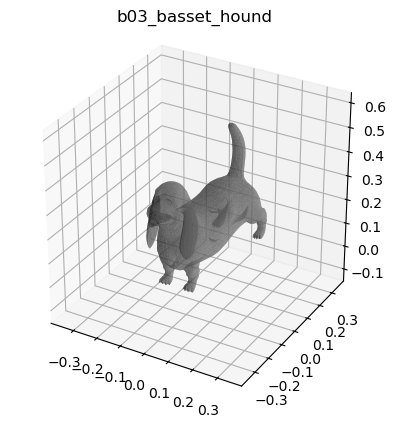

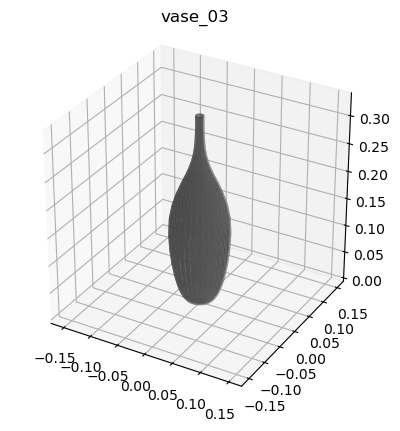

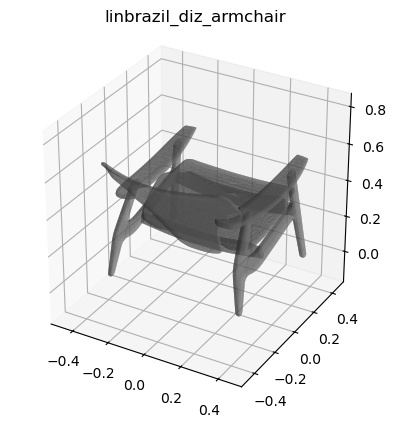

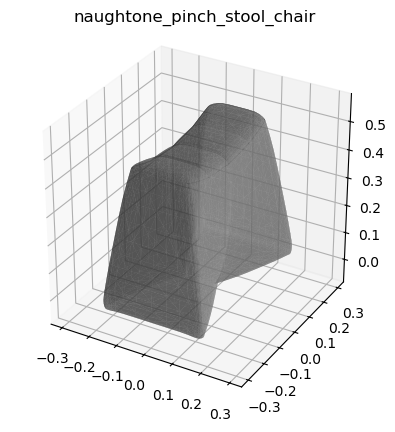

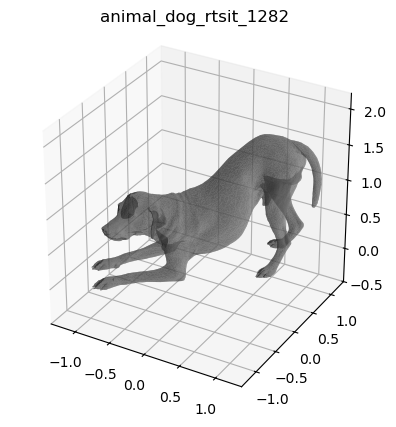

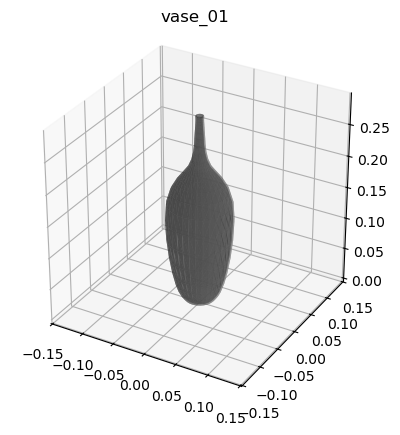

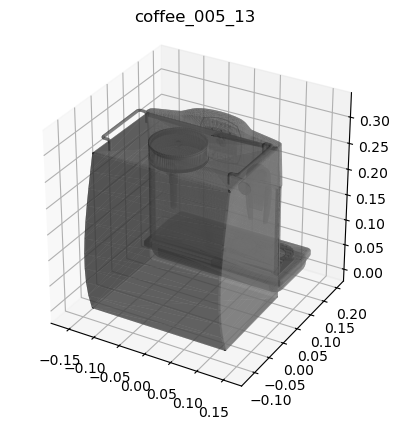

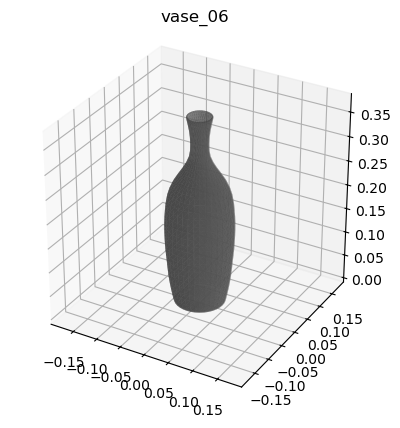

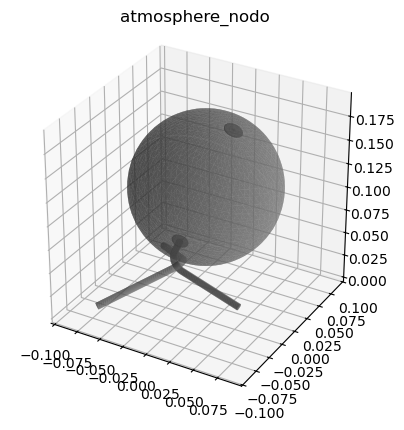

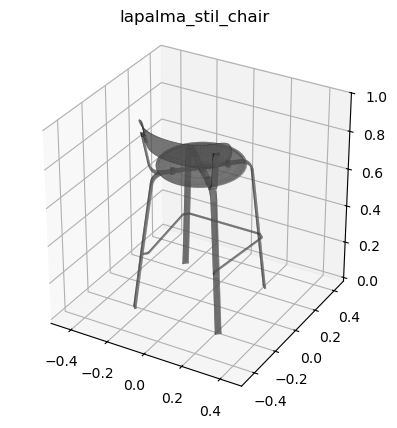

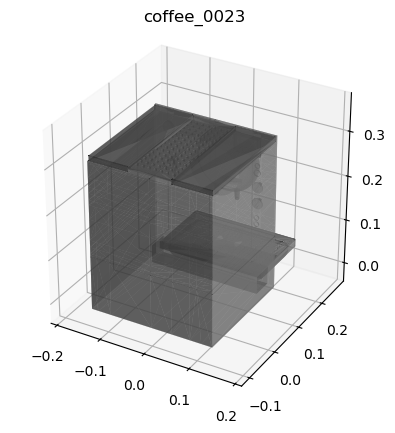

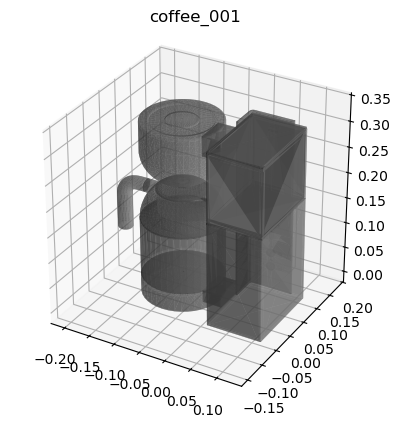

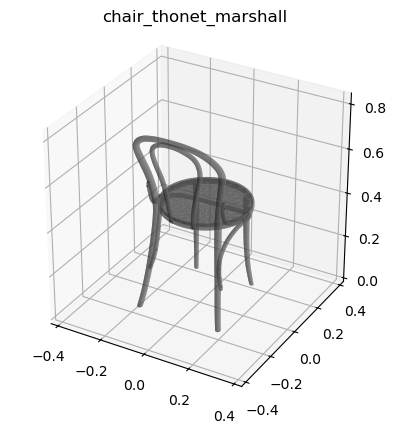

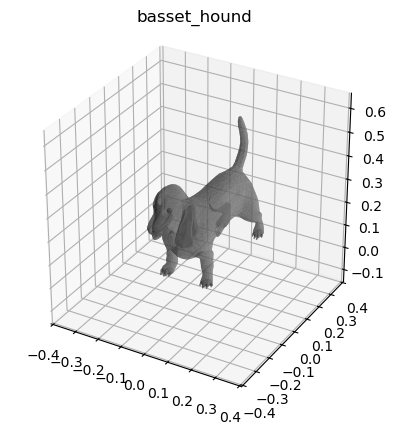

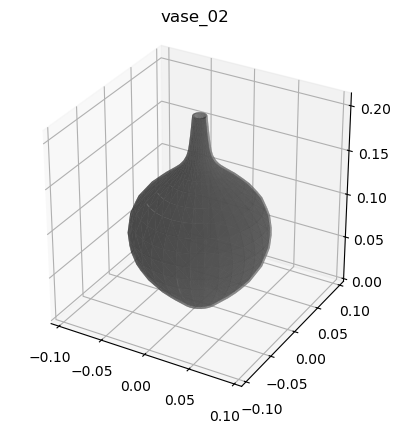

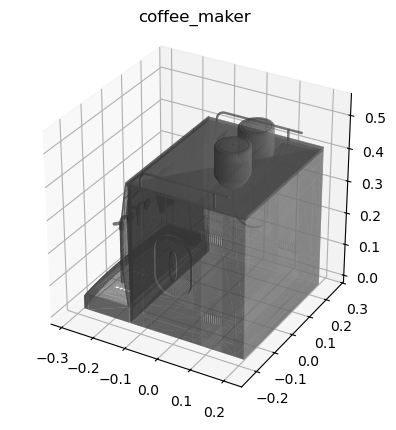

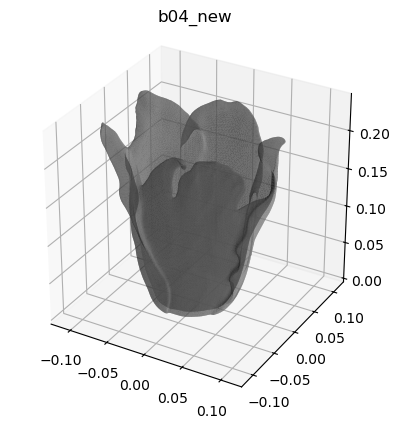

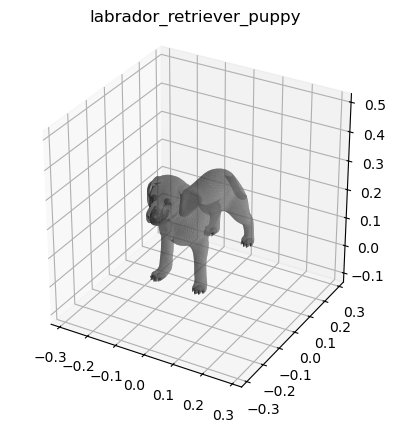

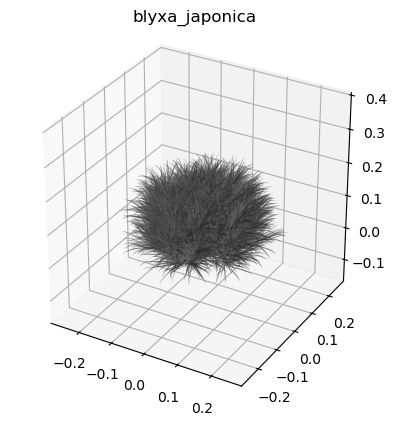

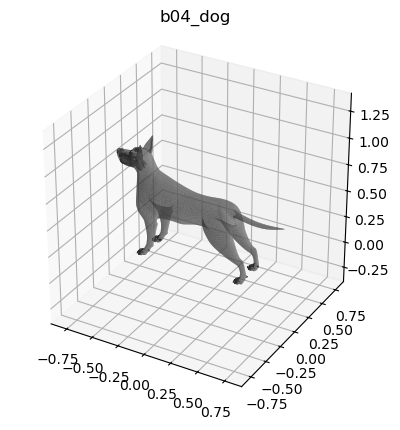

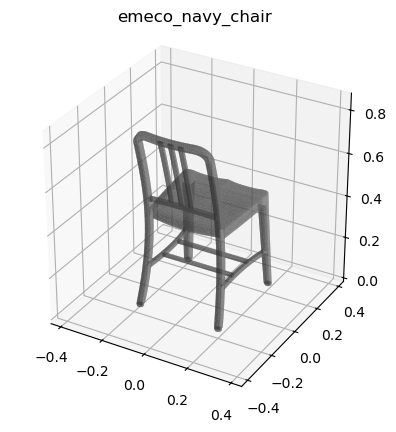

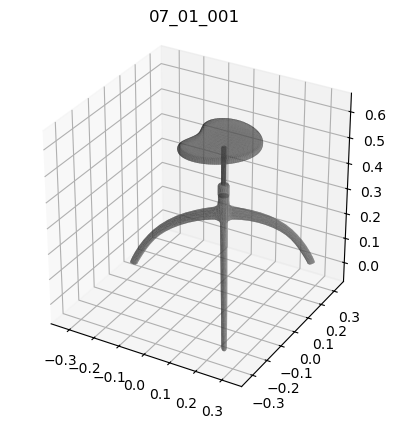

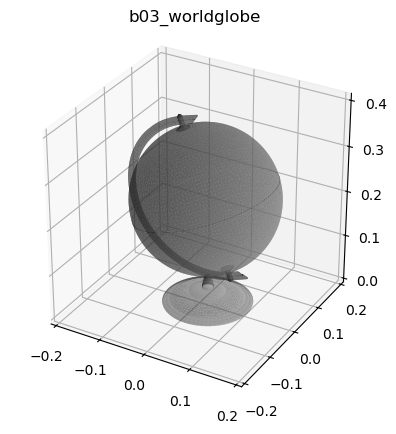

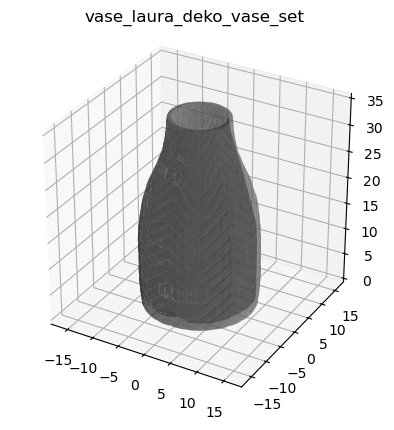

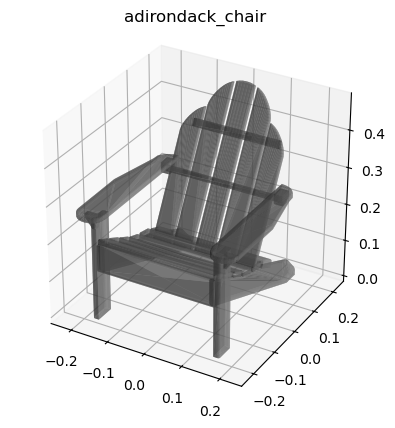

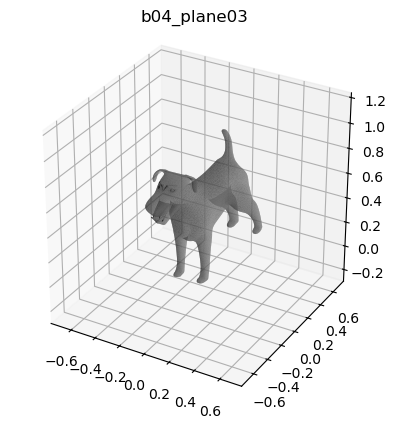

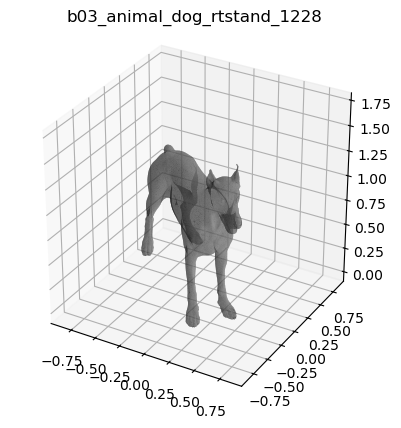

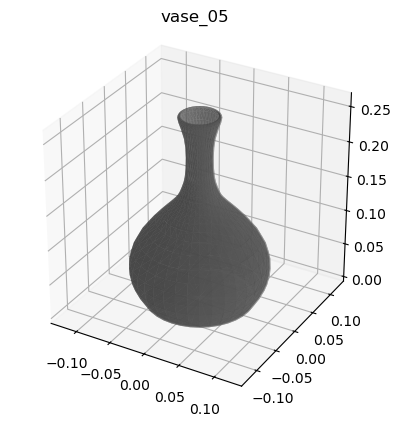

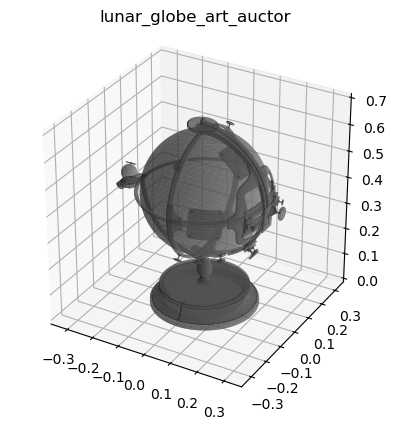

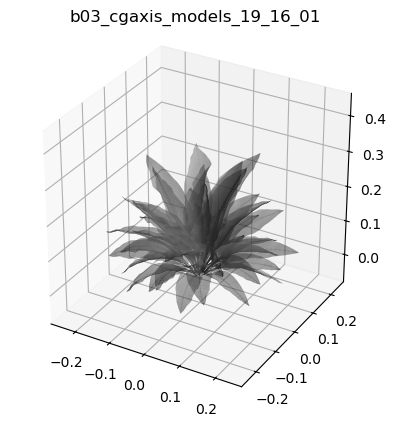

: 

In [19]:
for model_name, mesh in distractor_occluder.items():
    mesh = trimesh.Trimesh(vertices=mesh[0], faces=mesh[1])
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,2], mesh.vertices[:,1], triangles=mesh.faces, 
                    color=(0.5, 0.5, 0.5, 0.6))
    ax.set_title(f"{model_name}")
    set_axes_equal(ax)
